 # Case 3  Coronavirus Stock Market Crash

In [45]:
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn
from sklearn.cluster import KMeans

In [14]:
data = pd.read_csv("~/Desktop/SP500_DATA_FINAL.csv",sep=",",dtype={'Symbol':str,'Security':str,'GICS Sector':str})
data.head()

,Symbol,Security,GICS Sector,Price_0214(USD),Price_0323(USD),"MktCap_0214(USD,M)",Percentage Decline,Retention
0,MMM,3M Company,Industrials,161.01,117.87,92677.4,-26.79%,73.21%
1,ABT,Abbott Laboratories,Health Care,89.66,62.82,158559.7,-29.94%,70.06%
2,ABBV,AbbVie Inc.,Health Care,94.05,64.50,139083.1,-31.42%,68.58%
3,ABMD,ABIOMED Inc,Health Care,167.22,132.34,7535.4,-20.86%,79.14%
4,ACN,Accenture plc,Information Technology,212.37,143.69,134854.0,-32.34%,67.66%


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
Symbol                505 non-null object
Security              505 non-null object
GICS Sector           505 non-null object
Price_0214(USD)       505 non-null float64
Price_0323(USD)       505 non-null float64
MktCap_0214(USD,M)    505 non-null float64
Percentage Decline    505 non-null object
Retention             505 non-null object
dtypes: float64(3), object(5)
memory usage: 31.6+ KB


In [16]:
data['Percentage Decline'] = data['Percentage Decline'].replace('[%]', '', regex=True).astype(float)
data['Retention'] = data['Retention'].replace('[%]', '', regex=True).astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
Symbol                505 non-null object
Security              505 non-null object
GICS Sector           505 non-null object
Price_0214(USD)       505 non-null float64
Price_0323(USD)       505 non-null float64
MktCap_0214(USD,M)    505 non-null float64
Percentage Decline    505 non-null float64
Retention             505 non-null float64
dtypes: float64(5), object(3)
memory usage: 31.6+ KB


**Calculate aggregated variables for the 11 Sectors--decline rollup**

In [17]:
industry_number = data['GICS Sector'].value_counts()
data = pd.merge(data,industry_number,how='inner',left_on='GICS Sector',right_on=industry_number.index).drop(columns='GICS Sector_x')
data = data.rename(columns={'GICS Sector_y':'Industry_Count','Percentage Decline':'Percentage_Decline',
                          'MktCap_0214(USD,M)':'MktCap_0214'})

def calculate_weighted(data):
    return np.sum(data['MktCap_0214']*data['Percentage_Decline'])/sum(data['MktCap_0214'])

result = data.groupby('GICS Sector').apply(calculate_weighted)
# turn in to data frame
dict_combine = {'GICS Sector':result.index, 'Decline Rollup':result.values}
result_decline = pd.DataFrame(dict_combine)  # result for decline
result_decline

,GICS Sector,Decline Rollup
0,Communication Services,-28.983107
1,Consumer Discretionary,-31.000587
2,Consumer Staples,-23.500114
3,Energy,-55.771756
4,Financials,-43.828911
5,Health Care,-27.922046
6,Industrials,-42.094597
7,Information Technology,-30.756725
8,Materials,-36.575514
9,Real Estate,-38.997661


**Calculate aggregated variables for the 11 Sectors--rentention rollup**

In [18]:
def calculate_weighted_retention(data):
    return np.sum(data['MktCap_0214']*data['Retention'])/sum(data['MktCap_0214'])

result1 = data.groupby('GICS Sector').apply(calculate_weighted_retention)
# turn into data frame
dict_combine1 = {'GICS Sector':result1.index, 'Rentention Rollup':result1.values}
result_rentention = pd.DataFrame(dict_combine1)  # result for retention
result_rentention

,GICS Sector,Rentention Rollup
0,Communication Services,71.016893
1,Consumer Discretionary,68.999413
2,Consumer Staples,76.499886
3,Energy,44.228244
4,Financials,56.171089
5,Health Care,72.077954
6,Industrials,57.905403
7,Information Technology,69.243275
8,Materials,63.424486
9,Real Estate,61.002339


##  Clustering

### 1. Algorithm

In [19]:
class KMeans(BaseEstimator):

    def __init__(self, k, max_iter=300, random_state=0, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        self.labels_ = euclidean_distances(X, self.cluster_centers_,
                                     squared=True).argmin(axis=1)

    def _average(self, X):
        return X.mean(axis=0)

    def _m_step(self, X):
        X_center = None
        for center_id in range(self.k):
            center_mask = self.labels_ == center_id
            if not np.any(center_mask):
                # The centroid of empty clusters is set to the center of
                # everything
                if X_center is None:
                    X_center = self._average(X)
                self.cluster_centers_[center_id] = X_center
            else:
                self.cluster_centers_[center_id] = \
                    self._average(X[center_mask])

    def fit(self, X, y=None):
        n_samples = X.shape[0]
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.labels_ = random_state.permutation(n_samples)[:self.k]
        self.cluster_centers_ = X[self.labels_]

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self

class KMedians(KMeans):

    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)

    def _average(self, X):
        return np.median(X, axis=0)

### 1.1 K-means

In [20]:
# add Number to each company according to sector
data.sort_values('GICS Sector',inplace=True) #order by sector
data.index = range(505) # reset index
data['Number'] = data.index
X = data[['Retention','Number']]
#cluster part
estimator = KMeans(k=3)
estimator.fit(np.array(X.Retention).reshape(-1,1))
label_pred = pd.DataFrame(estimator.labels_)
result_label = pd.merge(X,label_pred,how='inner',left_on='Number',right_on=label_pred.index) 
result_label = result_label.rename(columns={0:'Label'})
x0 = X[result_label['Label'] == 0].to_numpy()
x1 = X[result_label['Label'] == 1].to_numpy()
x2 = X[result_label['Label'] == 2].to_numpy()
print(len(x0),len(x1),len(x2)) 

269 92 144


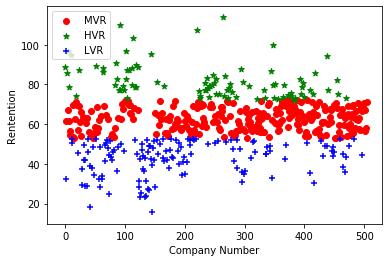

In [21]:
## plot
plt.scatter(x0[:, 1], x0[:, 0], c="red", marker='o', label='MVR')
plt.scatter(x1[:, 1], x1[:, 0], c="green", marker='*', label='HVR')
plt.scatter(x2[:, 1], x2[:, 0], c="blue", marker='+', label='LVR')
plt.xlabel('Company Number')
plt.ylabel('Rentention')
plt.legend(loc=2)
plt.show()


### 1.2 K-median

In [22]:
kmedians = KMedians(k=3)
kmedians.fit(np.array(X.Retention).reshape(-1,1))
label_pred2 = pd.DataFrame(kmedians.labels_)
result_label2 = pd.merge(X,label_pred2,how='inner',left_on='Number',right_on=label_pred2.index) 
result_label2 = result_label2.rename(columns={0:'Label'})  
x0_median = X[result_label2['Label'] == 0].to_numpy()
x1_median = X[result_label2['Label'] == 1].to_numpy()
x2_median = X[result_label2['Label'] == 2].to_numpy()
print(len(x0_median),len(x1_median),len(x2_median)) 



217 121 167


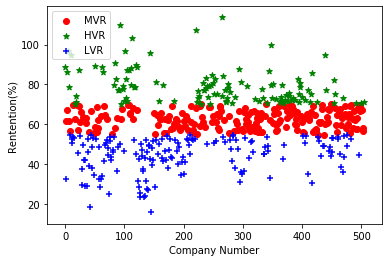

In [23]:
##plot
plt.scatter(x0_median[:, 1], x0_median[:, 0], c="red", marker='o', label='MVR')
plt.scatter(x1_median[:, 1], x1_median[:, 0], c="green", marker='*', label='HVR')
plt.scatter(x2_median[:, 1], x2_median[:, 0], c="blue", marker='+', label='LVR')
plt.xlabel('Company Number')
plt.ylabel('Rentention(%)')
plt.legend(loc=2)
plt.show()

### 1.3 Combination

In [24]:
## merge with orginal data
result_label2 = result_label2.drop(columns='Retention')
data = pd.merge(data,result_label2,how='inner',on='Number')
data.head(100)

,GICS Sector,Symbol,Security,Price_0214(USD),Price_0323(USD),MktCap_0214,Percentage_Decline,Retention,Industry_Count,Number,Label
0,Communication Services,ATVI,Activision Blizzard,63.52,56.47,48799.90,-11.10,88.90,26,0,1
1,Communication Services,DIS,The Walt Disney Company,139.54,85.76,251930.90,-38.54,61.46,26,1,0
2,Communication Services,VIAC,ViacomCBS,34.98,11.28,21720.70,-67.75,32.25,26,2,2
3,Communication Services,VZ,Verizon Communications,58.51,50.31,241997.40,-14.01,85.99,26,3,1
4,Communication Services,TWTR,"Twitter, Inc.",36.91,24.69,28600.00,-33.11,66.89,26,4,0
5,Communication Services,TTWO,Take-Two Interactive,113.43,109.82,12177.30,-3.18,96.82,26,5,1
6,Communication Services,TMUS,T-Mobile US,96.48,75.70,82676.90,-21.54,78.46,26,6,1
7,Communication Services,OMC,Omnicom Group,78.14,48.30,16946.00,-38.19,61.81,26,7,0
8,Communication Services,NWS,News Corp. Class B,14.98,8.14,7594.41,-45.66,54.34,26,8,2
9,Communication Services,NWSA,News Corp. Class A,14.60,8.23,8667.80,-43.63,56.37,26,9,0


### 1.4 cluster results for each sector

In [44]:
sector_distribution = data.groupby(['Label','GICS Sector'])['GICS Sector'].count()

result_cluster = []

for key,value in zip(sector_distribution.index,sector_distribution.values):
     result_cluster.append([key[0], key[1], value])   
result_cluster = pd.DataFrame(result_cluster, columns=['Label','GICS Sector', 'Count'])
result_cluster['Label'] = result_cluster['Label'].astype(str)
for i in range(len(result_cluster)):
    if result_cluster['Label'][i] == '0':
        result_cluster['Label'][i] = 'Median Value'
    if result_cluster['Label'][i] == '1':
        result_cluster['Label'][i] = 'High Value'
    if result_cluster['Label'][i] == '2':
        result_cluster['Label'][i] = 'NLow Value'
result_cluster = result_cluster.sort_values('Label')       
result_cluster

/Users/stanmiller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/stanmiller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/stanmiller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as

,Label,GICS Sector,Count
15,High Value,Health Care,30
20,High Value,Utilities,3
19,High Value,Real Estate,4
18,High Value,Materials,3
17,High Value,Information Technology,29
16,High Value,Industrials,12
14,High Value,Financials,4
13,High Value,Energy,1
12,High Value,Consumer Staples,20
11,High Value,Consumer Discretionary,6


## Result Analysis

The first step is to see the changes of company number in different clustering groups. The goal of this analysis is to find if there exists any industry or comany value pattern of standing against the crisis.
To make the graphs more clear, I sepeated the industries into three groups to plot into three graphs: 

Graph1: industries with higher retentions-Consumer Staples, Health Care, Communication Services, Information Technology

Graph2: industries with intermediate retentions-Consumer Discretionary, Utilities','Materials, Real Estate

Graph3: industries with lower retentions- Industrials, Financials, Energy

In [46]:
def newline(p1, p2, p3, color='black'):
        ax = plt.gca()
        l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p2[1]-p1[1] > 0 else 'green',marker='o', markersize=6)
        ax.add_line(l)
        l = mlines.Line2D([p2[0],p3[0]], [p2[1],p3[1]], color='red' if p3[1]-p2[1] > 0 else 'green',marker='o', markersize=6) 
        ax.add_line(l)
        return l
    
def Draw_graph(High, Median, Low, Label):
    left_label = [str(c) + ', '+ str(y) for c, y in zip(Label, High)]
    middle_label = [str(c) + ', '+ str(y) for c, y in zip(Label, Median)]
    right_label = [str(c) + ', '+ str(y) for c, y in zip(Label, Low)]
    klass1 = ['red' if (y1-y2) < 0 else 'green' for y1, y2 in zip(High, Median)]
    klass2 = ['red' if (y1-y2) < 0 else 'green' for y1, y2 in zip(Median, Low)]
    # draw line
    # https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941

    fig, ax = plt.subplots(1,1,figsize=(10,5), dpi= 80)

    # Vertical Lines
    ax.vlines(x=1, ymin=0, ymax=40, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
    ax.vlines(x=3, ymin=0, ymax=40, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
    ax.vlines(x=5, ymin=0, ymax=40, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
    # Points
    ax.scatter(y=High, x=np.repeat(1, len(High)), s=10, color='black', alpha=0.7)
    ax.scatter(y=Median, x=np.repeat(3, len(Median)), s=10, color='black', alpha=0.7)
    ax.scatter(y=Low, x=np.repeat(5, len(Low)), s=10, color='black', alpha=0.7)

    # Line Segmentsand Annotation
    for p1, p2, p3, c in zip(High, Median, Low, Label):
        newline([1,p1], [3,p2], [5,p3])
        ax.text(1-0.05, p1, c + ', ' + str(p1), horizontalalignment='right', verticalalignment='center', fontdict={'size':10})
        ax.text(3+0.05, p2, c + ', ' + str(p2), horizontalalignment='left', verticalalignment='center', fontdict={'size':10})
        ax.text(5+0.05, p3, c + ', ' + str(p3), horizontalalignment='left', verticalalignment='center', fontdict={'size':10})

    # Three Clustering Groups Annotations
    ax.text(1+0.05, 40, 'High Value', horizontalalignment='left', verticalalignment='center', fontdict={'size':13, 'weight':700})
    ax.text(3+0.05, 40, 'Median Value', horizontalalignment='left', verticalalignment='center', fontdict={'size':13, 'weight':700})
    ax.text(5+0.05, 40, 'Low Value', horizontalalignment='left', verticalalignment='center', fontdict={'size':13, 'weight':700})

    # Decoration
    ax.set(xlim=(0,6), ylim=(0,40), ylabel='Company Number')
    ax.set_xticks([1,3,5])
    ax.set_xticklabels(["'High Value Group", "'Median Value Group","Low Value Group"])


    # Lighten borders
    plt.gca().spines["top"].set_alpha(.0)
    plt.gca().spines["bottom"].set_alpha(.0)
    plt.gca().spines["right"].set_alpha(.0)
    plt.gca().spines["left"].set_alpha(.0)
    return plt.show()


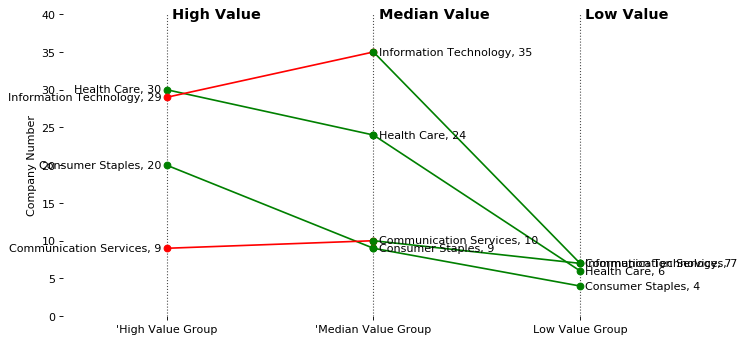

In [47]:
High = [20, 30, 9, 29]
Label = ['Consumer Staples', 'Health Care', 'Communication Services', 'Information Technology']
Median = [9, 24, 10, 35]
Low = [4, 6, 7, 7]
Draw_graph(High, Median, Low, Label)

As we can see from the graph above, industries that have higher average retentions generally contain more high-value companies while fewer low-value companies.

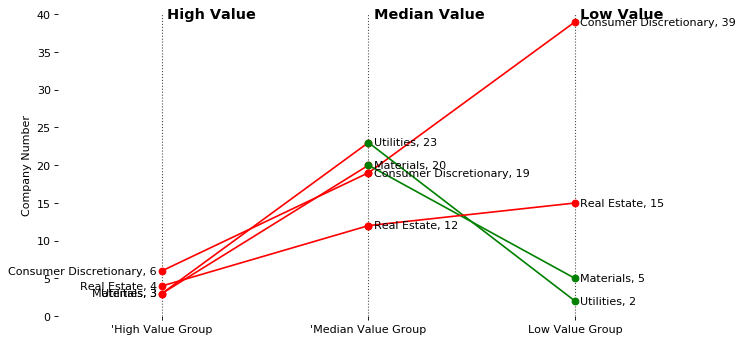

In [43]:
# Import Data
High = [6, 3, 3, 4]
Label = ['Consumer Discretionary', 'Utilities','Materials', 'Real Estate']
Median = [19, 23, 20, 12]
Low = [39, 2, 5, 15]
Draw_graph(High, Median, Low, Label)

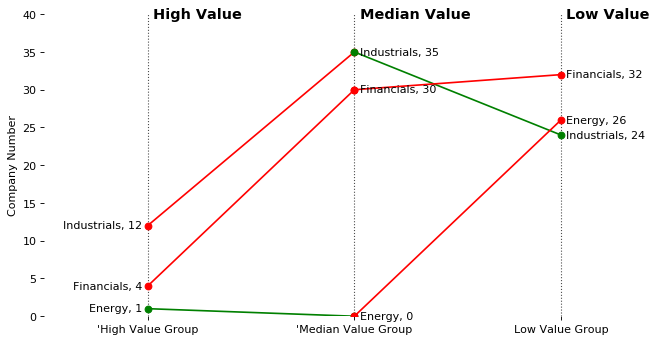

In [44]:
# Import Data
High = [12, 4, 1]
Label = ['Industrials', 'Financials', 'Energy']
Median = [35, 30, 0]
Low = [24, 32, 26]
Draw_graph(High, Median, Low, Label)

## Analysis in selected industries

### 1. Consumer Discretionary

1.1 To see how much market value does each cluster have for Consumer Discretionary


In [66]:
temp = data[data['GICS Sector']=='Consumer Discretionary'][['Label','Retention','MktCap_0214']].groupby('Label').sum()
temp

,Retention,MktCap_0214
Label,,
0,1172.16,1150924.00
1,516.80,1210969.40
2,1657.41,702800.31


1.2 To see the portion of each value group for aggregated market value and retention.

[Text(0.5, 1.0, 'Total Retention for Each Cluster')]

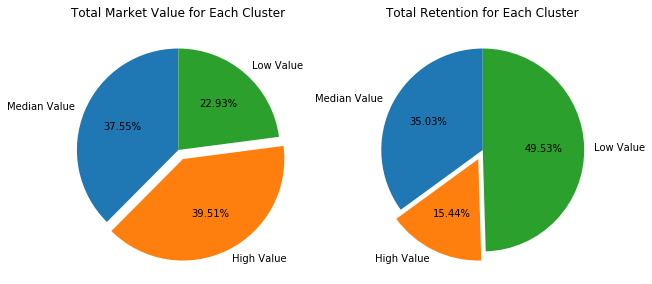

In [67]:
figsize = [10, 4.8]
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=figsize)
label_name = ['Median Value', 'High Value', 'Low Value']
axes[0].pie(temp['MktCap_0214'],explode=[0,0.1,0],autopct='%.2f%%',
         labels = label_name, startangle=90)
axes[1].pie(temp['Retention'],explode=[0,0.1,0],autopct='%.2f%%',
         labels = label_name, startangle=90)
axes[0].set(title='Total Market Value for Each Cluster')
axes[1].set(title='Total Retention for Each Cluster')

1.3 what are the listed companies in Consumer Discretionary, along with their market value?

In [52]:
detail_data = pd.read_excel('~/Desktop/SP500_DATA_ALL.xlsx',sep=",")
detail_data.head(5)

,Symbol,Security,GICS Sector,GICS Sub Industry,Ticker,Name,Price_0214(USD),Price_0323(USD),"MktCap_0214(USD,M)",Name_Match,Primary Sector,Primary Industry,Business Description,Industry Classifications,Headquarters - Country/Region,Website,SEC filings
0,MMM,3M Company,Industrials,Industrial Conglomerates,MMM,3M Company,161.01,117.87,92677.4,3M Company (NYSE:MMM),Industrials,Industrial Conglomerates,"3M Company develops, manufactures, and markets...",Capital Goods (Primary); Industrial Conglomera...,United States,www.3m.com,reports
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,ABT,Abbott Laboratories,89.66,62.82,158559.7,Abbott Laboratories (NYSE:ABT),Health Care,Health Care Equipment,"Abbott Laboratories discovers, develops, manuf...",Health Care (Primary); Health Care Equipment (...,United States,www.abbott.com,reports
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,ABBV,AbbVie Inc.,94.05,64.50,139083.1,AbbVie Inc. (NYSE:ABBV),Health Care,Biotechnology,"AbbVie Inc., a research-based biopharmaceutica...",Biotechnology (Primary); Biotechnology (Primar...,United States,www.abbvie.com,reports
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment,ABMD,"Abiomed, Inc.",167.22,132.34,7535.4,"Abiomed, Inc. (NasdaqGS:ABMD)",Health Care,Health Care Equipment,"Abiomed, Inc. engages in the research, develop...",Cardiovascular Equipment (Primary); Health Car...,United States,www.abiomed.com,reports
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,ACN,Accenture plc,212.37,143.69,134854.0,Accenture plc (NYSE:ACN),Information Technology,IT Consulting and Other Services,"Accenture plc provides consulting, technology,...",Information Technology (Primary); Information ...,Ireland,www.accenture.com,reports


In [53]:
temp = data[(data['GICS Sector']=='Consumer Discretionary')&(data['Label']==1)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp

,Security,Retention,MktCap_0214
51,Amazon.com Inc.,89.13,1062760.6
86,Target Corp.,82.90,59100.8
63,Dollar General,88.51,40234.5
64,Dollar Tree,86.12,20987.2
85,Tiffany & Co.,90.62,16264.3
83,Tractor Supply Company,79.52,11622.0


([<matplotlib.patches.Wedge at 0x1a20f95400>,
 [Text(-1.1123855916595853, 0.45010920393628373, 'Amazon.com Inc.'),
  Text(0.8980279673384973, -0.6352525244954853, 'Target Corp.'),
  Text(1.0302739342035103, -0.3854031921258843, 'Dollar General'),
  Text(1.0782615959293949, -0.21760498786515592, 'Dollar Tree'),
  Text(1.094227132060704, -0.11254769416654835, 'Tiffany & Co.'),
  Text(1.0995000555618406, -0.03316063659687058, 'Tractor Supply Company')],
 [Text(-0.6488915951347579, 0.2625637022961655, '87.76%'),
  Text(0.4898334367300894, -0.3465013769975374, '4.88%'),
  Text(0.5619676004746419, -0.21021992297775505, '3.32%'),
  Text(0.5881426886887607, -0.11869362974463049, '1.73%'),
  Text(0.5968511629422021, -0.06138965136357182, '1.34%'),
  Text(0.5997273030337311, -0.018087619961929407, '0.96%')])

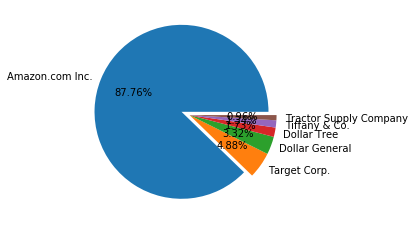

In [119]:
fig,axes = plt.subplots()
axes.pie(temp['MktCap_0214'],labels=temp['Security'],explode=[0.1,0,0,0,0,0],autopct='%.2f%%',)          

The GICS Sub Industry & Primary Industry of Those listed companies.

In [54]:
table = pd.DataFrame(columns=['Security','GICS Sub Industry'])
for company in list(temp['Security']):
    table = table.append(detail_data[detail_data['Security']==company][['Security','GICS Sub Industry']],ignore_index=True)
table['GICS Sub Industry'].value_counts()

General Merchandise Stores             3
Apparel, Accessories & Luxury Goods    1
Internet & Direct Marketing Retail     1
Specialty Stores                       1
Name: GICS Sub Industry, dtype: int64

1.4 what are the companies in Consumer Discretionary lower clustering group, along with their market value?

In [55]:
temp = data[(data['GICS Sector']=='Consumer Discretionary')&(data['Label']==2)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp.head(4)

,Security,Retention,MktCap_0214
26,Lowe's Cos.,54.06,96131.3
69,General Motors,50.63,49672.1
46,Marriott Int'l.,48.40,47373.2
75,Ross Stores,51.67,43704.7


Their GICS Sub Industry & Primary Industry

In [56]:
table = pd.DataFrame(columns=['Security','GICS Sub Industry'])
for company in list(temp['Security']):
    table = table.append(detail_data[detail_data['Security']==company][['Security','GICS Sub Industry']],ignore_index=True)
table.head(5)

,Security,GICS Sub Industry
0,Lowe's Cos.,Home Improvement Retail
1,General Motors,Automobile Manufacturers
2,Marriott Int'l.,"Hotels, Resorts & Cruise Lines"
3,Ross Stores,Apparel Retail
4,Ford Motor Company,Automobile Manufacturers


In [115]:
table['GICS Sub Industry'].value_counts()

Apparel, Accessories & Luxury Goods    6
Hotels, Resorts & Cruise Lines         4
Homebuilding                           4
Specialty Stores                       3
Apparel Retail                         3
Casinos & Gaming                       2
Restaurants                            2
Department Stores                      2
Automobile Manufacturers               2
Home Furnishings                       2
Household Appliances                   1
General Merchandise Stores             1
Auto Parts & Equipment                 1
Leisure Products                       1
Housewares & Specialties               1
Home Improvement Retail                1
Internet & Direct Marketing Retail     1
Distributors                           1
Motorcycle Manufacturers               1
Name: GICS Sub Industry, dtype: int64

### 2. Financial Sector

Use the same analysis logic as that of Consumer Discretionary.

In [69]:
temp = data[data['GICS Sector']=='Financials'][['Label','Retention','MktCap_0214']].groupby('Label').mean()
temp

,Retention,MktCap_0214
Label,,
0,61.250667,50221.693333
1,76.025000,98329.225000
2,45.880625,50255.646875


In [70]:
temp = data[data['GICS Sector']=='Financials'][['Label','Retention','MktCap_0214']].groupby('Label').sum()
temp

,Retention,MktCap_0214
Label,,
0,1837.52,1506650.8
1,304.10,393316.9
2,1468.18,1608180.7


[Text(0.5, 1.0, 'Total Retention for Each Cluster')]

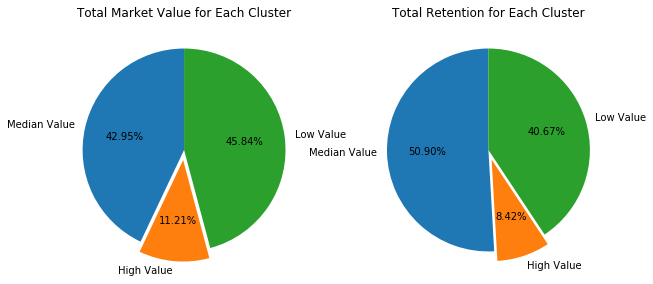

In [71]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=figsize)
label_name = ['Median Value','High Value','Low Value']
axes[0].pie(temp['MktCap_0214'],explode=[0,0.1,0],autopct='%.2f%%',
         labels=label_name, startangle=90)
axes[1].pie(temp['Retention'],explode=[0,0.1,0],autopct='%.2f%%',
         labels=label_name, startangle=90)
axes[0].set(title='Total Market Value for Each Cluster')
axes[1].set(title='Total Retention for Each Cluster')

The pattern here is different from that of Consumer Discretionary. Most companies in this sector are low-value companies.

In [72]:
temp = data[(data['GICS Sector']=='Financials')&(data['Label']==1)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp

,Security,Retention,MktCap_0214
183,Berkshire Hathaway,71.49,303912.0
165,Progressive Corp.,79.44,48971.9
159,MSCI Inc,71.79,27323.2
154,MarketAxess,81.38,13109.8


The companies which have higher retention, on the other hand, have lower market.

In [74]:
table = pd.DataFrame(columns=['Security','GICS Sub Industry'])
for company in list(temp['Security']):
    table = table.append(detail_data[detail_data['Security']==company][['Security','GICS Sub Industry']],ignore_index=True)
table['GICS Sub Industry'].value_counts()

Financial Exchanges & Data       2
Property & Casualty Insurance    1
Multi-Sector Holdings            1
Name: GICS Sub Industry, dtype: int64

low-value companies

In [75]:
temp = data[(data['GICS Sector']=='Financials')&(data['Label']==2)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp.head(10)

,Security,Retention,MktCap_0214
185,Bank of America Corp,51.88,307939.8
214,Wells Fargo,52.36,199362.0
210,Citigroup Inc.,44.92,166577.3
191,American Express Co,50.75,109788.5
158,Morgan Stanley,49.80,90382.5
177,U.S. Bancorp,52.50,84538.7
176,Truist Financial,46.76,73738.6
163,PNC Financial Services,52.32,66738.3
156,MetLife Inc.,45.01,47851.9
171,Capital One Financial,41.77,46865.4


It is superising that companies in lower value group are actually big names.  

In [76]:
table = pd.DataFrame(columns=['Security','GICS Sub Industry'])
for company in list(temp['Security']):
    table = table.append(detail_data[detail_data['Security']==company][['Security','GICS Sub Industry']],ignore_index=True)
table

,Security,GICS Sub Industry
0,Bank of America Corp,Diversified Banks
1,Wells Fargo,Diversified Banks
2,Citigroup Inc.,Diversified Banks
3,American Express Co,Consumer Finance
4,Morgan Stanley,Investment Banking & Brokerage
5,U.S. Bancorp,Diversified Banks
6,Truist Financial,Regional Banks
7,PNC Financial Services,Regional Banks
8,MetLife Inc.,Life & Health Insurance
9,Capital One Financial,Consumer Finance


In [77]:
table['GICS Sub Industry'].value_counts()

Regional Banks                      10
Life & Health Insurance              6
Diversified Banks                    5
Consumer Finance                     4
Property & Casualty Insurance        3
Asset Management & Custody Banks     2
Investment Banking & Brokerage       1
Multi-line Insurance                 1
Name: GICS Sub Industry, dtype: int64

### 3. Energy Sector

In [78]:
temp = data[data['GICS Sector']=='Energy'][['Label','Retention','MktCap_0214']].groupby('Label').sum()
temp

,Retention,MktCap_0214
Label,,
1,95.54,6037.3
2,977.05,1044191.1


[Text(0.5, 1.0, 'Total Retention for Each Cluster')]

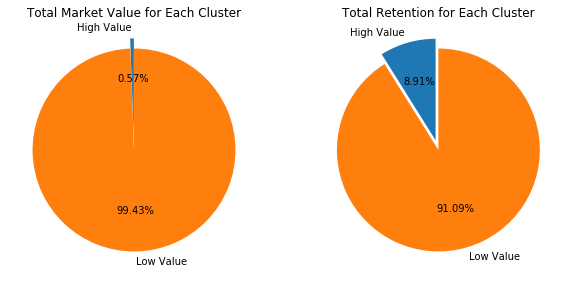

In [79]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=figsize)
label_name = ['High Value', 'Low Value']
axes[0].pie(temp['MktCap_0214'],explode=[0.1,0],autopct='%.2f%%',
         labels=label_name, startangle=90)
axes[1].pie(temp['Retention'],explode=[0.1,0],autopct='%.2f%%',
         labels=label_name, startangle=90)
axes[0].set(title='Total Market Value for Each Cluster')
axes[1].set(title='Total Retention for Each Cluster')

In [80]:
##energy high value compay
temp = data[(data['GICS Sector']=='Energy')&(data['Label']==1)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp

,Security,Retention,MktCap_0214
143,Cabot Oil & Gas,95.54,6037.3


In [81]:
table = pd.DataFrame(columns=['Security','GICS Sub Industry'])
for company in list(temp['Security']):
    table = table.append(detail_data[detail_data['Security']==company][['Security','GICS Sub Industry']],ignore_index=True)
table['GICS Sub Industry'].value_counts()

Oil & Gas Exploration & Production    1
Name: GICS Sub Industry, dtype: int64

low-value companies

In [82]:
temp = data[(data['GICS Sector']=='Energy')&(data['Label']==2)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp

,Security,Retention,MktCap_0214
137,Exxon Mobil Corp.,51.85,256792.1
142,Chevron Corp.,49.26,208147.2
148,ConocoPhillips,41.88,63595.0
128,Kinder Morgan,50.14,49831.4
131,Schlumberger Ltd.,37.27,47655.0
138,EOG Resources,46.10,43585.8
129,Phillips 66,47.04,39756.7
124,Marathon Petroleum,28.49,37856.2
133,Occidental Petroleum,23.29,37162.0
146,Valero Energy,39.47,33936.3


In [83]:
table = pd.DataFrame(columns=['Security','GICS Sub Industry'])
for company in list(temp['Security']):
    table=table.append(detail_data[detail_data['Security']==company][['Security','GICS Sub Industry']],ignore_index=True)
table
table['GICS Sub Industry'].value_counts()

Oil & Gas Exploration & Production    10
Oil & Gas Equipment & Services         5
Oil & Gas Refining & Marketing         4
Integrated Oil & Gas                   3
Oil & Gas Storage & Transportation     3
Oil & Gas Drilling                     1
Name: GICS Sub Industry, dtype: int64

### 4. Consumer Staples

In [84]:
temp = data[data['GICS Sector']=='Consumer Staples'][['Label','Retention','MktCap_0214']].groupby('Label').sum()
temp

,Retention,MktCap_0214
Label,,
0,597.89,681558.0
1,1668.21,1524858.9
2,193.48,101088.5


[Text(0.5, 1.0, 'Total Retention for Each Cluster')]

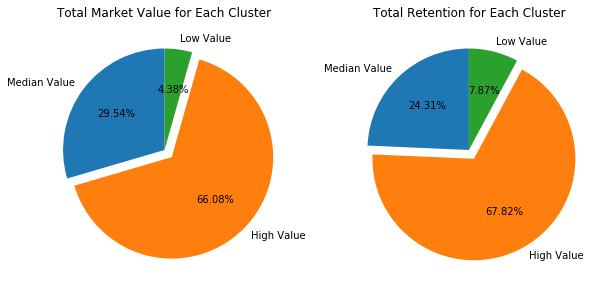

In [85]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=figsize)
label_name = ['Median Value', 'High Value', 'Low Value']
axes[0].pie(temp['MktCap_0214'],explode=[0,0.1,0],autopct='%.2f%%',
         labels=label_name, startangle=90)
axes[1].pie(temp['Retention'],explode=[0,0.1,0],autopct='%.2f%%',
         labels=label_name, startangle=90)
axes[0].set(title='Total Market Value for Each Cluster')
axes[1].set(title='Total Retention for Each Cluster')

high value

In [86]:
temp = data[(data['GICS Sector']=='Consumer Staples')&(data['Label']==1)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp

,Security,Retention,MktCap_0214
101,Walmart,96.94,334474.6
98,Procter & Gamble,77.45,311496.8
105,PepsiCo Inc.,71.56,204249.2
119,Costco Wholesale Corp.,89.70,140615.9
95,Mondelez International,70.26,85518.0
118,Colgate-Palmolive,78.85,65726.7
90,Kimberly-Clark,77.18,49751.8
102,Walgreens Boots Alliance,82.52,46817.8
103,Monster Beverage,72.96,37562.4
91,Kraft Heinz Co,77.27,32831.2


In [147]:
table=pd.DataFrame(columns=['Security','GICS Sub Industry'])
for company in list(temp['Security']):
    table=table.append(detail_data[detail_data['Security']==company][['Security','GICS Sub Industry']],ignore_index=True)
table['GICS Sub Industry'].value_counts()

Packaged Foods & Meats          9
Household Products              4
Soft Drinks                     2
Hypermarkets & Super Centers    2
Personal Products               1
Food Retail                     1
Drug Retail                     1
Name: GICS Sub Industry, dtype: int64

low value

In [87]:
temp = data[(data['GICS Sector']=='Consumer Staples')&(data['Label']==2)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp

,Security,Retention,MktCap_0214
99,Sysco Corp.,46.38,39770.5
117,Constellation Brands,51.83,38736.5
93,Lamb Weston Holdings Inc,50.13,13903.6
120,"Coty, Inc",45.14,8677.9


In [88]:
table = pd.DataFrame(columns=['Security','GICS Sub Industry'])
for company in list(temp['Security']):
    table = table.append(detail_data[detail_data['Security']==company][['Security','GICS Sub Industry']],ignore_index=True)
table
table['GICS Sub Industry'].value_counts()

Packaged Foods & Meats    1
Personal Products         1
Distillers & Vintners     1
Food Distributors         1
Name: GICS Sub Industry, dtype: int64

In [191]:
temp=data[(data['GICS Sector']=='Health Care')&(data['Label']==1)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp

,Security,Retention,MktCap_0214
265,Johnson & Johnson,74.03,395123.0
275,Merck & Co.,80.34,210425.6
274,Pfizer Inc.,78.03,202050.8
244,Abbott Laboratories,70.06,158559.7
257,Thermo Fisher Scientific,75.27,136012.2
267,Lilly (Eli) & Co.,84.36,135493.7
237,Amgen Inc.,83.20,131810.0
225,Danaher Corp.,73.15,115418.2
226,CVS Health,74.39,92849.8
220,Gilead Sciences,107.47,85473.2


In [89]:
temp = data[(data['GICS Sector']=='Health Care')&(data['Label']==2)][['Security','Retention','MktCap_0214']].sort_values('MktCap_0214',ascending=False)
temp

,Security,Retention,MktCap_0214
219,HCA Healthcare,52.66,50730.9
251,Zimmer Biomet Holdings,50.38,32991.8
269,IQVIA Holdings Inc.,51.12,31884.3
239,Align Technology,50.09,21669.6
266,Laboratory Corp. of America Holding,53.42,18981.2
255,"Universal Health Services, Inc.",51.34,12255.0
